# Argon on Graphene

In [1]:
using FreeBird
using Plots
using Statistics
using Distributions
using DataFrames
using CSV

In [2]:
function plot_lattice(lattice::LatticeSystem, title::String)
    plot_lattice = plot(title=title, legend=false, aspect_ratio=:equal)
    num_positions = size(lattice.positions, 1)
    
    for index in 1:num_positions
        x, y = lattice.positions[index, :]
        scatter!(plot_lattice, [x], [y], color=:blue, markersize=10)
        annotate!(plot_lattice, x, y, text(index, 10, :white))
    end
    
    return plot_lattice
end

plot_lattice (generic function with 1 method)

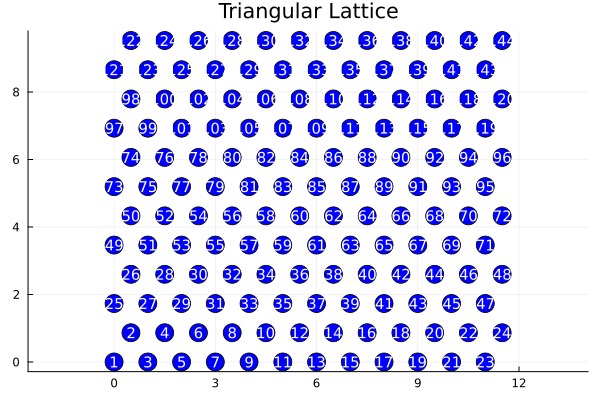

In [3]:
lattice_constant = 1.0
primitive_lattice_vectors = [lattice_constant 0.0 0.0; 0.0 sqrt(3) * lattice_constant 0.0; 0.0 0.0 1.0]
basis = [(0.0, 0.0, 0.0), (1/2, sqrt(3)/2, 0.0)]
supercell_dimensions = (12, 6, 1)
periodicity = (true, true, false)
occupations = [true for i in 1:supercell_dimensions[1]*supercell_dimensions[2]*length(basis)]
adsorptions = [true for i in 1:supercell_dimensions[1]*supercell_dimensions[2]*length(basis)]
cutoff_radii = (1.1, 1.9)
triangular_lattice = LatticeSystem(
    primitive_lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)
plot_triangular = plot_lattice(triangular_lattice, "Triangular Lattice")

In [4]:
triangular_lattice.neighbors[60]

([58, 59, 61, 62, 83, 85], [36, 57, 63, 81, 84, 87])

## MCMC Algorithm

N = 8 -------------------
T = 200
T = 199
T = 198
T = 197
T = 196
T = 195
T = 194
T = 193
T = 192
T = 191
T = 190
T = 189
T = 188
T = 187
T = 186
T = 185
T = 184
T = 183
T = 182
T = 181
T = 180
T = 179
T = 178
T = 177
T = 176
T = 175
T = 174
T = 173
T = 172
T = 171
T = 170
T = 169
T = 168
T = 167
T = 166
T = 165
T = 164
T = 163
T = 162
T = 161
T = 160
T = 159
T = 158
T = 157
T = 156
T = 155
T = 154
T = 153
T = 152
T = 151
T = 150
T = 149
T = 148
T = 147
T = 146
T = 145
T = 144
T = 143
T = 142
T = 141
T = 140
T = 139
T = 138
T = 137
T = 136
T = 135
T = 134
T = 133
T = 132
T = 131
T = 130
T = 129
T = 128
T = 127
T = 126
T = 125
T = 124
T = 123
T = 122
T = 121
T = 120
T = 119
T = 118
T = 117
T = 116
T = 115
T = 114
T = 113
T = 112
T = 111
T = 110
T = 109
T = 108
T = 107
T = 106
T = 105
T = 104
T = 103
T = 102
T = 101
T = 100
T = 99
T = 98
T = 97
T = 96
T = 95
T = 94
T = 93
T = 92
T = 91
T = 90
T = 89
T = 88
T = 87
T = 86
T = 85
T = 84
T = 83
T = 82
T = 81
T = 80
T = 79
T = 78
T = 77
T = 7

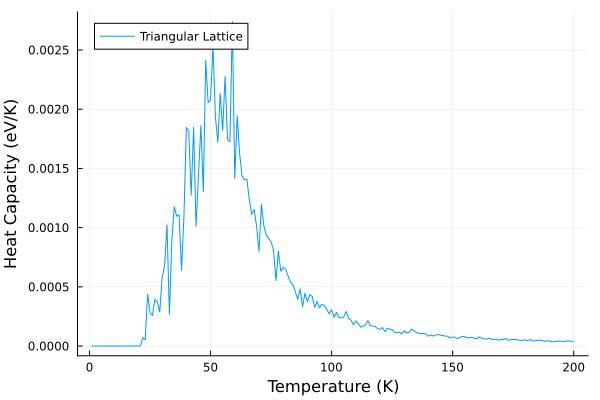

In [5]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for MCMC simulation
# https://doi.org/10.1039/D3CP01285A
L = supercell_dimensions[1]
M = supercell_dimensions[2]
Ns = [8]
adsorption_energy = -0.005438 * 6  # eV
nn_energy = 1.73  # eV
nnn_energy = -0.00797  # eV
temperatures = 200:-1:1
num_equilibration_steps = 10_000
num_sampling_steps = 10_000
random_seed = 1234

# Define file paths for data
parameters = "mc_triangular_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"

# Perform the Monte Carlo simulation if data files do not exist
if !isfile(cv_file)

    # Initialize a DataFrame to store the results
    df_samples = DataFrame(N = Int[], T = Float64[], E = Float64[], Cv = Float64[], acceptance_rate = Float64[])
    
    # Perform the Monte Carlo simulation
    for N in Ns
        println("N = $N -------------------")

        # Initialize the lattice
        occupations = [false for i in 1:L*M*length(basis)]
        for i in sample(1:length(occupations), N, replace=false)
            occupations[i] = true
        end
        initial_lattice = LatticeSystem(
            primitive_lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            occupations,
            adsorptions,
            cutoff_radii
        )

        for temp in temperatures
            println("T = $temp")

            # Equilibrate the lattice
            temperature = Float64(temp)
            equilibration_energies, equilibration_configurations, equilibration_accepted_steps = nvt_monte_carlo(
                initial_lattice,
                adsorption_energy,
                nn_energy,
                nnn_energy,
                temperature,
                num_equilibration_steps,
                random_seed
            )

            # Sample the lattice
            sampling_energies, sampling_configurations, sampling_accepted_steps = nvt_monte_carlo(
                equilibration_configurations[end],
                adsorption_energy,
                nn_energy,
                nnn_energy,
                temperature,
                num_sampling_steps,
                random_seed
            )

            # Compute the heat capacity
            E = mean(sampling_energies)
            Cv = var(sampling_energies) / (k_B * temperature^2)

            # Compute the acceptance rate
            acceptance_rate = sampling_accepted_steps / num_sampling_steps

            # Append the results to the DataFrame
            append!(df_samples, DataFrame(N = N, T = temperature, E = E, Cv = Cv, acceptance_rate = acceptance_rate))

            # Update the initial lattice
            initial_lattice = deepcopy(sampling_configurations[end])
        end
    end

    # Write DataFrame to a CSV file
    CSV.write(cv_file, df_samples)
else
    println("Data files already exist.")
end

# Read the DataFrame from the CSV file
df_samples = CSV.read(cv_file, DataFrame)

# Plot the heat capacity
plot(df_samples.T, df_samples.Cv, xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", label="Triangular Lattice", legend=:topleft)

## Wang-Landau Sampling

In [8]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for Wang-Landau simulation
num_steps = 10000
flatness_criterion = 0.8
f_initial = Float64(MathConstants.e)
f_min = exp(10^-8)
energy_min = 8 * adsorption_energy + 8 * 6 * nnn_energy
energy_max = 8 * adsorption_energy + 8 * 6 * nn_energy
num_energy_bins = 10000
energy_bins = collect(range(energy_min, stop=energy_max, length=num_energy_bins))

# Initialize the lattice
occupations = [false for i in 1:L*M*length(basis)]
for i in sample(1:length(occupations), Ns[1], replace=false)
    occupations[i] = true
end
initial_lattice = LatticeSystem(
    primitive_lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)

# Define file paths for data
parameters = "wl_triangular_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
entropy_file = "data/entropy_$parameters.csv"

# Perform the Wang-Landau simulation if data files do not exist
if !isfile(entropy_file)
    entropy, histogram, bin_energies, energies, configurations = wang_landau(
        initial_lattice,
        adsorption_energy,
        nn_energy,
        nnn_energy,
        num_steps,
        flatness_criterion,
        f_initial,
        f_min,
        energy_bins,
        random_seed
    )

    # Write the entropy to a CSV file
    df_entropy = DataFrame(energy = bin_energies, entropy = entropy)
    CSV.write(entropy_file, df_entropy)
else
    println("Data files already exist.")
end

f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 2.718281828459045
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.6487212707001282
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.0644944589178595
f = 1.0644944589178595
f = 1.064

### Analyzing the Results

#### Density of States

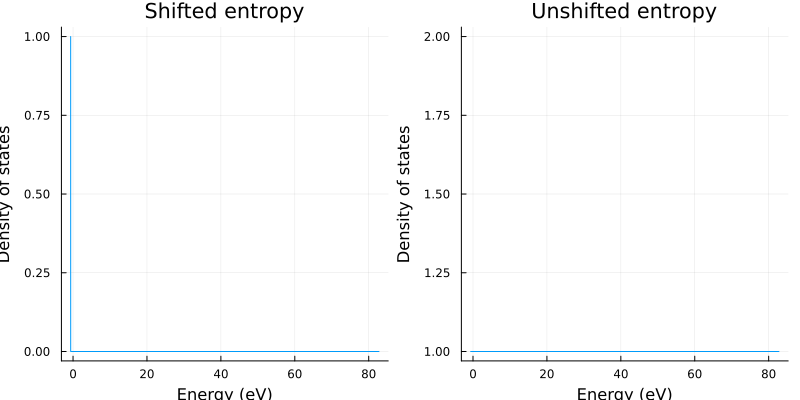

In [8]:
df_wl = CSV.read(entropy_file, DataFrame)
S_shifted = df_wl.entropy .- minimum(df_wl.entropy[df_wl.entropy .> 0])
g = exp.(S_shifted)
E = df_wl.energy

# Plot g(E)
p1 = plot(E, g, xlabel="Energy (eV)", ylabel="Density of states", legend=false, title="Shifted entropy")

# Plot exp.(df_entropy.entropy)
p2 = plot(E, exp.(df_wl.entropy), xlabel="Energy (eV)", ylabel="Density of states", legend=false, title="Unshifted entropy")

# Display the plots
plot(p1, p2, layout=(1, 2), size=(800, 400))

#### Ensemble Averages

In [31]:
# Compute the partition function as a function of temperature
E_rel = E .- minimum(E)
T = collect(1.0:0.1:200.0)
Z = zeros(length(T))
for (i, temp) in enumerate(T)
    Z[i] = sum(exp.(-E_rel ./ (k_B * temp)) .* g)
end

# Plot the partition function
# plot(T, Z, xlabel="Temperature (K)", ylabel="Partition function", legend=false, title="Partition function")

# Compute the average energy as a function of temperature
E_avg = zeros(length(T))
for (i, temp) in enumerate(T)
    E_avg[i] = sum(E_rel .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
end

# Plot the average energy
# plot(T, E_avg, xlabel="Temperature (K)", ylabel="Average energy (eV)", legend=false, title="Average energy")

# Compute the average energy squared as a function of temperature
E2_avg = zeros(length(T))
for (i, temp) in enumerate(T)
    E2_avg[i] = sum(E_rel.^2 .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
end

# Compute the heat capacity as a function of temperature
Cv = (E2_avg .- E_avg.^2) ./ (k_B * T.^2) / k_B

1991-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Nested Sampling

Data files already exist.


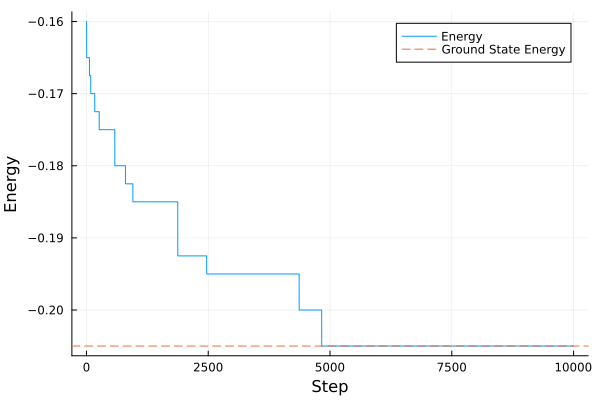

In [7]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize walkers with random configurations
num_walkers = 1000
walkers = [deepcopy(initial_lattice) for i in 1:num_walkers]
for walker in walkers
    walker.occupations = [false for i in 1:length(walker.occupations)]
    for i in sample(1:length(walker.occupations), Ns[1], replace=false)
        walker.occupations[i] = true
    end
end

# Define parameters for nested sampling simulation
num_steps = 10000
perturbation = 1e-10

# Define file paths for data
parameters = "ns_square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(square_cutoff_radii[1])_$(square_cutoff_radii[2])"
energy_file = "data/energy_$parameters.csv"

# Perform the nested sampling simulation if data files do not exist
if !isfile(energy_file)
    results = nested_sampling(
        walkers,
        num_steps,
        adsorption_energy,
        nn_energy,
        nnn_energy,
        perturbation
    )

    # Write the energy to a CSV file
    df_energy = DataFrame(step = 1:num_steps, energy = results[3])
    CSV.write(energy_file, df_energy)
else
    println("Data files already exist.")
end

# Plot the results
df_ns = CSV.read(energy_file, DataFrame)
plot(df_ns.energy, xlabel="Step", ylabel="Energy", label="Energy")

# Add a horizontal line for the ground state energy
ground_state_energy = 20.5 * nn_energy
hline!([ground_state_energy], label="Ground State Energy", linestyle=:dash)

### Analyzing the Results

#### Partition Function

The partition function $Z$ can be computed from the results of nested sampling. It is defined as:
$$
Z = \sum_i \omega_i e^{-\beta E_i}
$$
where
$$
\omega_i = \frac{1}{K + 1} \left( \frac{K}{K + 1} \right)^i
$$
and $K$ is the number of walkers in the nested sampling algorithm.

#### Ensemble Averages

The average energy $\langle E \rangle$ and the specific heat $C_V$ can be computed using the partition function. The average energy is given by:
$$
\langle E \rangle = \frac{1}{Z} \sum_i E_i \omega_i e^{-\beta E_i}
$$

The average energy squared $\langle E^2 \rangle$ is calculated as:
$$
\langle E^2 \rangle = \frac{1}{Z} \sum_i E_i^2 \omega_i e^{-\beta E_i}
$$

In [8]:
# Compute ω_i
ω_0 = 16 * 15 * 14 * 13 / 4 / 3 / 2 / 1  # 16 choose 4
ω_i = ω_0 * (1 / num_walkers) * (num_walkers / (num_walkers + 1)) .^ (collect(1:num_steps))

# Compute the partition function as a function of temperature
Z = zeros(length(T))
E_i_ns = df_ns.energy
E_rel_i_ns = E_i_ns .- minimum(E_i_ns)
for (i, temp) in enumerate(T)
    Z[i] = sum(exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i)
end

# Compute the average energy as a function of temperature
E_avg_i_ns = zeros(length(T))
for (i, temp) in enumerate(T)
    E_avg_i_ns[i] = sum(E_rel_i_ns .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
end

# Compute the average energy squared as a function of temperature
E2_avg_i_ns = zeros(length(T))
for (i, temp) in enumerate(T)
    E2_avg_i_ns[i] = sum(E_rel_i_ns.^2 .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
end

# Compute the heat capacity as a function of temperature
Cv_i_ns = (E2_avg_i_ns .- E_avg_i_ns.^2) ./ (k_B * T.^2) / k_B

1991-element Vector{Float64}:
 1.0790451782508405e-13
 8.917730765617771e-14
 7.493507939310394e-14
 6.389755133087135e-14
 5.6071755666922725e-14
 6.201648770079673e-14
 1.8077739714171258e-13
 1.0739590839256624e-12
 6.191682275889103e-12
 3.018173293411991e-11
 ⋮
 0.271814526375257
 0.2715410611228207
 0.27126799956666553
 0.27099534092982985
 0.270723084437173
 0.2704512293153796
 0.27017977479294797
 0.2699087201001897
 0.26963806446922023

## Replica Exchange

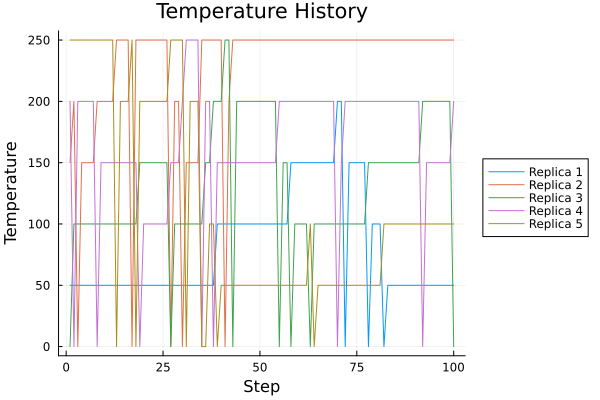

Bool[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Bool[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1]
Bool[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Bool[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]


In [9]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize replicas with random configurations
num_replicas = 5
replicas = [deepcopy(initial_lattice) for _ in 1:num_replicas]
for replica in replicas
    replica.occupations = [false for i in 1:length(replica.occupations)]
    for i in sample(1:length(replica.occupations), 4, replace=false)
        replica.occupations[i] = true
    end
end

# Define parameters for replica exchange simulation
temperatures = [50., 100., 150., 200., 250.]  # K
num_steps = 100  # 10000
swap_fraction = 0.1  # 10% swap, 90% displacement
for replica in replicas
    println(replica.occupations)
end

# Run the simulation
replicas, energies, temperature_history = nvt_replica_exchange(
    replicas,
    temperatures,
    num_steps,
    adsorption_energy,
    nn_energy,
    nnn_energy,
    swap_fraction
)

# Plot the temperature history
p = plot(title="Temperature History", xlabel="Step", ylabel="Temperature", legend=:outerright)
for i in 1:num_replicas
    plot!(p, temperature_history[:, i], label="Replica $i")
end
display(p)

## Results

The temperature at which the maximum specific heat peak occurs is identified as the phase transition temperature. This peak signifies the onset of the order-disorder phase transition. 

The exact enumeration method serves as a benchmark for determining the phase transition temperature. In contrast, the MCMC and Wang-Landau algorithms provide efficient and accurate estimates of this temperature.

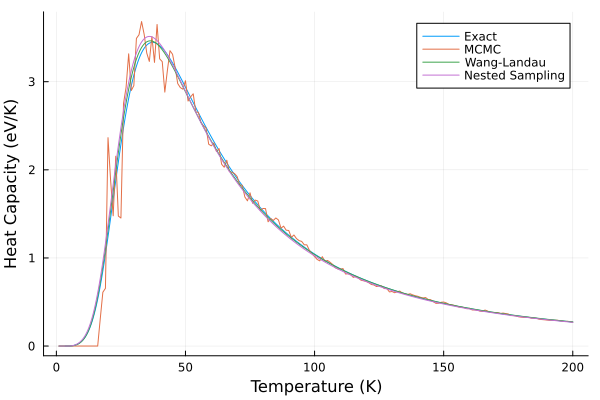

In [10]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read exact enumeration results
df_exact = CSV.read("data/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Read MCMC results
df_mcmc = CSV.read("data/Cv_mc_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Extract the data for N = 4
df_exact = filter(row -> row.N == 4, copy(df_exact))
df_mcmc = filter(row -> row.N == 4, copy(df_mcmc))

# Create a heat capacity vs. temperature plot with exact enumeration, MCMC, and Wang-Landau results
heat_capacity_plot = plot(df_exact.T, df_exact.Cv, xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", label="Exact", grid=true)
plot!(heat_capacity_plot, df_mcmc.T, df_mcmc.Cv / k_B, label="MCMC")
plot!(heat_capacity_plot, T, Cv, label="Wang-Landau")
plot!(heat_capacity_plot, T, Cv_i_ns, label="Nested Sampling")

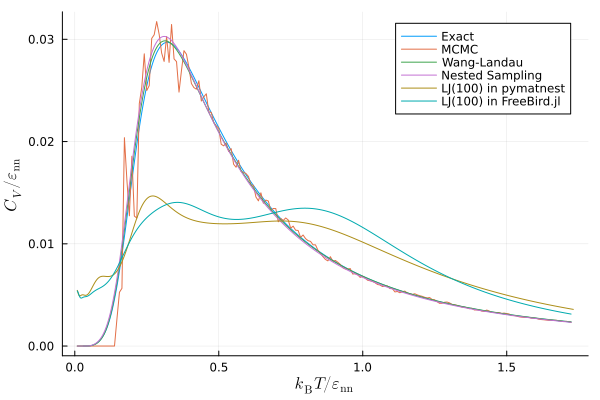

In [11]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read nested sampling results for LJ(100)
df_ns_lj100_pymatnest = CSV.read("data/Cv_ns_LJ_100_pymatnest.csv", DataFrame)
df_ns_lj100_FreeBird = CSV.read("data/Cv_ns_LJ_100_FreeBird.csv", DataFrame)

# # Create a heat capacity vs. temperature plot with exact enumeration, MCMC, and Wang-Landau results
heat_capacity_plot = plot(df_exact.T * k_B / -nn_energy, df_exact.Cv * k_B / -nn_energy, xlabel="\$ k_{\\mathrm{B}} T / \\varepsilon_{\\mathrm{nn}} \$", ylabel="\$ C_V / \\varepsilon_{\\mathrm{nn}} \$", label="Exact", grid=true)
plot!(heat_capacity_plot, df_mcmc.T * k_B / -nn_energy, df_mcmc.Cv / -nn_energy, label="MCMC")
plot!(heat_capacity_plot, T * k_B / -nn_energy, Cv * k_B / -nn_energy, label="Wang-Landau")
plot!(heat_capacity_plot, T * k_B / -nn_energy, Cv_i_ns * k_B / -nn_energy, label="Nested Sampling")
plot!(heat_capacity_plot, df_ns_lj100_pymatnest.temp * k_B / 0.1, (df_ns_lj100_pymatnest.cv_eV_per_K .- (3 / 2 * 4 * k_B)) / 0.1, label="LJ(100) in pymatnest")
plot!(heat_capacity_plot, df_ns_lj100_FreeBird.T * k_B / 0.1, (df_ns_lj100_FreeBird.C_V .- (3 / 2 * 4 * k_B)) / 0.1, label="LJ(100) in FreeBird.jl")